# Problem Statement

Car Data-
Here, we will apply k-means clustering for grouping the similar cars in one cluster

In [1]:
#Import all the necessary modules
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
from IPython.display import Image  
from os import system
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
np.random.seed(1234)

In [2]:
def plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True):
    cm = metrics.confusion_matrix(Y_test, Y_predict)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    print(metrics.classification_report(Y_test, Y_predict))
    model_performance = [metrics.accuracy_score(Y_test, Y_predict),metrics.recall_score(Y_test, Y_predict),
                         metrics.precision_score(Y_test, Y_predict),metrics.f1_score(Y_test, Y_predict) ]
    accuracy_report = pd.DataFrame(model_performance, columns=['Model_Performance'], 
                                   index=['Accuracy','Recall','Precision','f1_Score'])
    return accuracy_report
    
def EDA_Corr(df):
    corr = df.corr()
    index = corr.columns
    Output = []
    for i in range(0,len(index)):
        i = index[i]
        Pos = corr.index[(corr[i] >= 0.5)].tolist()
        No = corr.index[(corr[i] < 0.5) & (corr[i] > -0.6)].tolist()
        Neg = corr.index[(corr[i] <= -0.5)].tolist()
        leng_u = len(No)
        leng_pos = len(Pos)
        leng_neg = len(Neg)
        Out = [i, leng_u, leng_pos, leng_neg, Pos, Neg, No]
        Output.append(Out)
    fig, ax = plt.subplots(figsize=(20,10))  
    sns.heatmap(corr,annot=True,vmin=-1,vmax=1,cmap='Blues', linewidths=0, ax = ax)
    Output1 = pd.DataFrame(Output, columns= ['Feature','Uniqueness','Positive rel', 'inverse rel', 'Pos', 'Neg', 'No'])
    return Output1

def EDA(df):
    EDA = pd.DataFrame((df.describe()).T)
    EDA["Kurtosis"] = df.kurtosis()
    EDA["Skewness"] = df.skew()
    EDA["Range"] = EDA['max'] -  EDA['min']
    EDA["IQR"] = EDA['75%'] -  EDA['25%']
    return EDA

# Q1. Load the Cars Data file into Python DataFrame and view top 10 rows.

Get the data from here - https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

In [3]:
colnames = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
cars_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", '\s+', names = colnames)

In [4]:
cars_df.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl


# Q2 Print the datatypes of each column and the shape of the dataset. Perform descriptive analysis 

In [5]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 24.9+ KB


In [6]:
cars_df.shape

(398, 9)

In [7]:
 (cars_df.iloc[:0:7])[~(cars_df.iloc[:0:7]).applymap(np.isreal).all(1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name


In [8]:
#Converting Cylinders and Origin which by definition don't have numeric significance into Categorical data
cars_df["cylinders"] = pd.Categorical(cars_df["cylinders"])
cars_df["origin"] = pd.Categorical(cars_df["origin"])

In [9]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null category
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null category
car name        398 non-null object
dtypes: category(2), float64(4), int64(1), object(2)
memory usage: 19.7+ KB


In [10]:
# We see here that there are no missing values, however we see that 'horsepower' is an object while it should be an integer/float
# If we go back and see the information regarding the data, we see that the 'horsepower' field has 6 missing values, which are '?'
cars_df[cars_df['horsepower']=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [11]:
cars_df['horsepower'] = cars_df['horsepower'].replace('?',0)

In [12]:
cars_df['horsepower'] = cars_df['horsepower'].replace('?',cars_df['horsepower'].median())

In [13]:
cars_df['horsepower'] = pd.to_numeric(cars_df['horsepower'])
cars_df.groupby('car name')['horsepower'].median()

car name
amc ambassador brougham            175.0
amc ambassador dpl                 190.0
amc ambassador sst                 150.0
amc concord                         90.0
amc concord d/l                    120.0
amc concord dl                       0.0
amc concord dl 6                    90.0
amc gremlin                        100.0
amc hornet                          98.5
amc hornet sportabout (sw)         110.0
amc matador                        110.0
amc matador (sw)                   150.0
amc pacer                           90.0
amc pacer d/l                       95.0
amc rebel sst                      150.0
amc spirit dl                       80.0
audi 100 ls                         90.0
audi 100ls                          93.0
audi 4000                           78.0
audi 5000                          103.0
audi 5000s (diesel)                 67.0
audi fox                            83.0
bmw 2002                           113.0
bmw 320i                           110.0
buick c

In [14]:
EDA=EDA(cars_df)

In [15]:
EDA

,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skewness,Range,IQR
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6,-0.510781,0.457066,37.6,11.50
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0,-0.746597,0.719645,387.0,157.75
horsepower,398.0,102.894472,40.269544,0.0,75.000,92.0,125.000,230.0,0.844941,0.787889,230.0,50.00
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0,-0.785529,0.531063,3527.0,1384.25
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8,0.419497,0.278777,16.8,3.35
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0,-1.181232,0.011535,12.0,6.00


In [16]:
cars_df[cars_df['horsepower']==0]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,0.0,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,0.0,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,0.0,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,0.0,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,0.0,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,0.0,3035.0,20.5,82,1,amc concord dl


In [17]:
cars_df['horsepower'] = cars_df['horsepower'].replace(0,cars_df['horsepower'].median())

In [18]:
cars_df.describe()

,mpg,displacement,horsepower,weight,acceleration,model year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,193.425879,104.281407,2970.424623,15.568090,76.010050
std,7.815984,104.269838,38.229470,846.841774,2.757689,3.697627
min,9.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,104.250000,76.000000,2223.750000,13.825000,73.000000
50%,23.000000,148.500000,92.000000,2803.500000,15.500000,76.000000
75%,29.000000,262.000000,125.000000,3608.000000,17.175000,79.000000
max,46.600000,455.000000,230.000000,5140.000000,24.800000,82.000000


For Univariate Plots

In [19]:
cars_cols = [col_name for col_name in cars_df.drop(['car name'], axis=1).columns]

In [20]:
len(cars_cols)

8

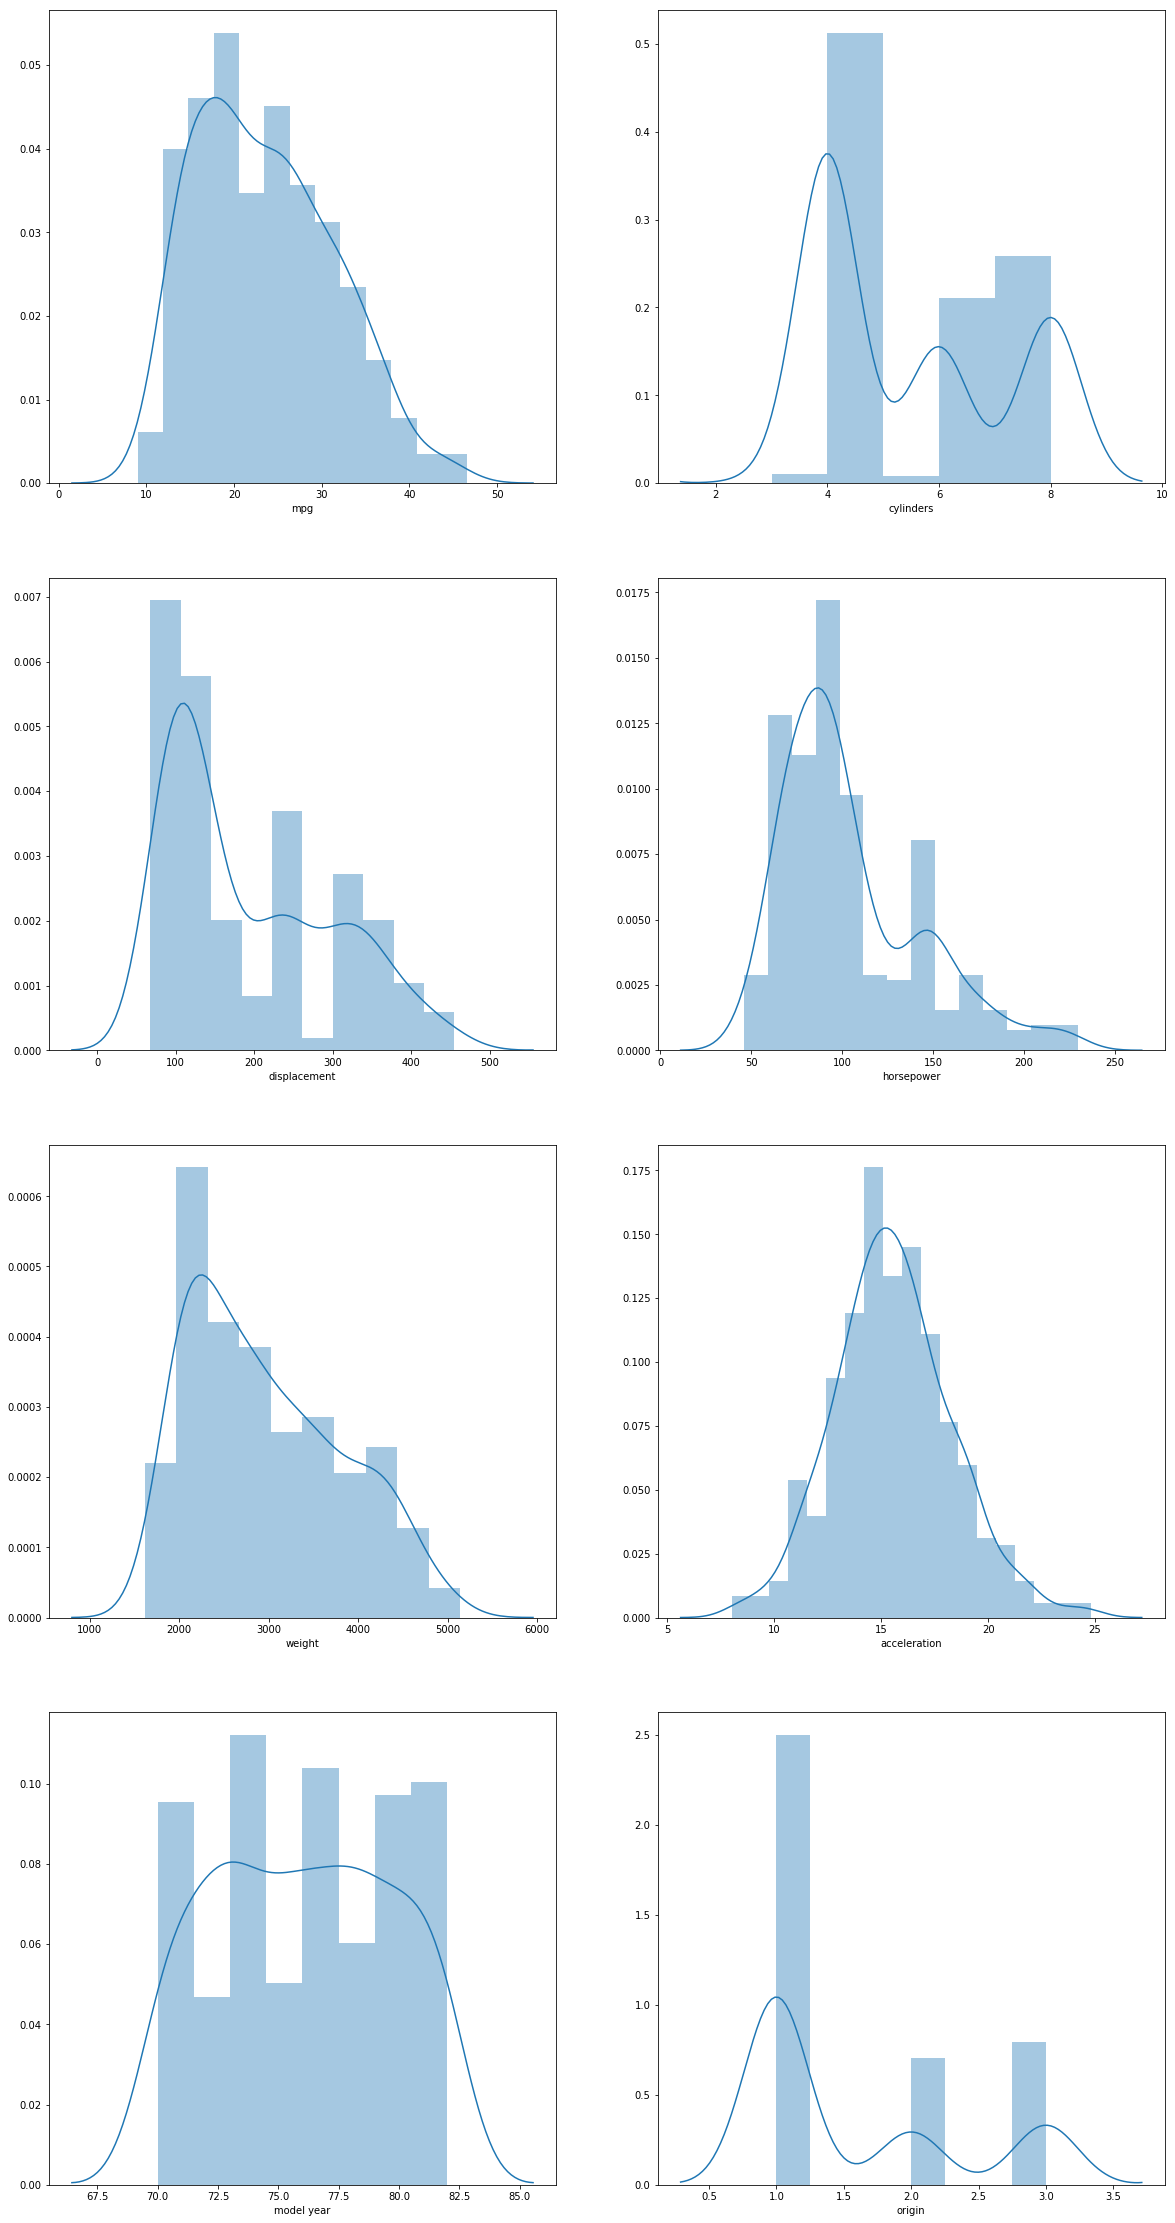

In [21]:
f,axs= plt.subplots(nrows = 4,ncols = 2,figsize=(20,40))
for i in range(0, len(cars_cols)):
    rows = i // 2
    cols = i % 2
    ax = axs[(rows, cols)]
    plot=sns.distplot(cars_df[cars_cols[i]],ax=ax); 

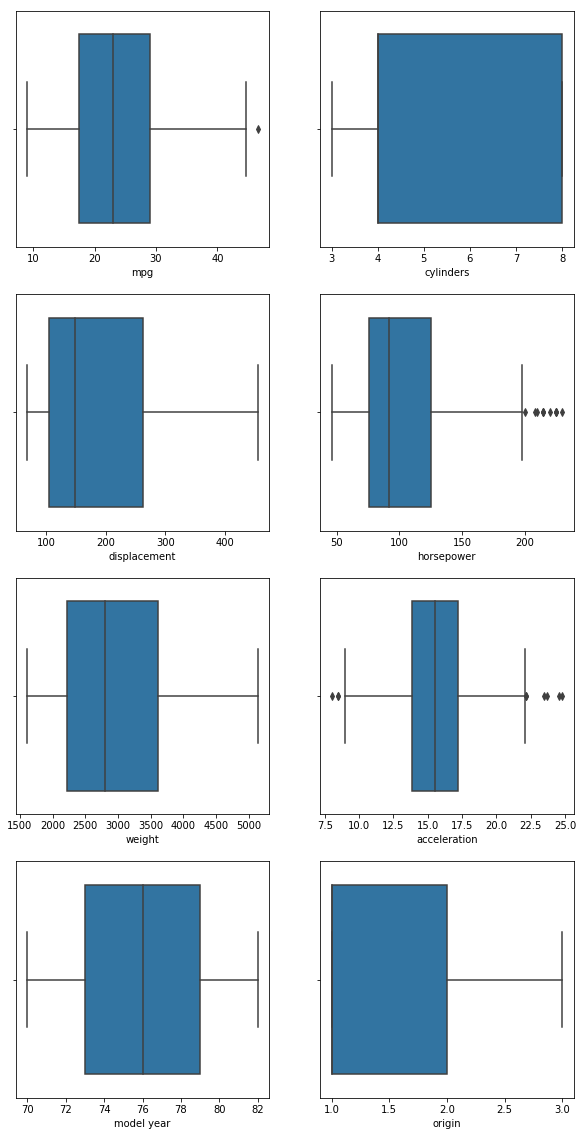

In [22]:
f,axs= plt.subplots(nrows = 4,ncols = 2,figsize=(10,20))
for i in range(0, len(cars_cols)):
    rows = i // 2
    cols = i % 2
    ax = axs[(rows, cols)]
    plot=sns.boxplot(cars_df[cars_cols[i]],ax=ax); 

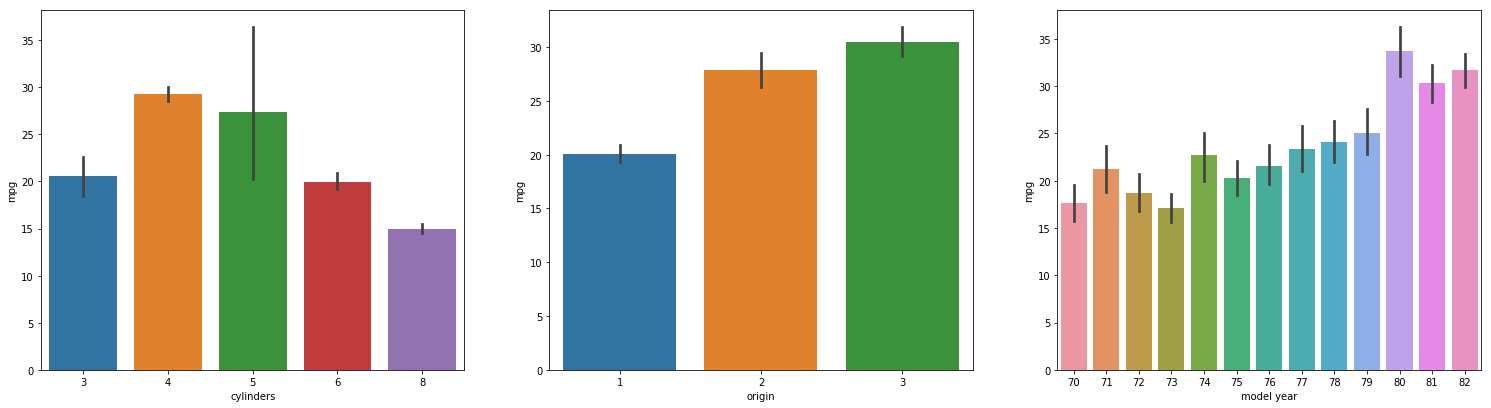

In [23]:
f, axes = plt.subplots(1, 3, figsize=(10, 10))
sns.barplot(x = 'cylinders', y = 'mpg', data = cars_df, ax = axes[0])
sns.barplot(x = 'origin', y = 'mpg', data = cars_df, ax = axes[1])
sns.barplot(x = 'model year', y = 'mpg', data = cars_df, ax = axes[2])
plt.subplots_adjust(top =  1.5, right = 10, left = 8, bottom = 1)

In [24]:
cars_df['model year'].value_counts()

73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: model year, dtype: int64

In [25]:
cars_df['car name'].value_counts()

ford pinto                              6
ford maverick                           5
amc matador                             5
toyota corolla                          5
toyota corona                           4
amc hornet                              4
peugeot 504                             4
chevrolet impala                        4
chevrolet chevette                      4
amc gremlin                             4
chevrolet vega                          3
pontiac catalina                        3
chevrolet citation                      3
ford gran torino                        3
volkswagen dasher                       3
plymouth duster                         3
dodge colt                              3
ford galaxie 500                        3
chevrolet nova                          3
chevrolet caprice classic               3
plymouth fury iii                       3
honda civic                             3
subaru                                  2
honda accord                      

In [26]:
cars_df['origin'].value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

# Q3 Check for missing value check, incorrect data and perform imputation with mean, median, mode as necessary.

Already done above

# Q4. Perform bi variate analysis including correlation, pairplots and state the inferences

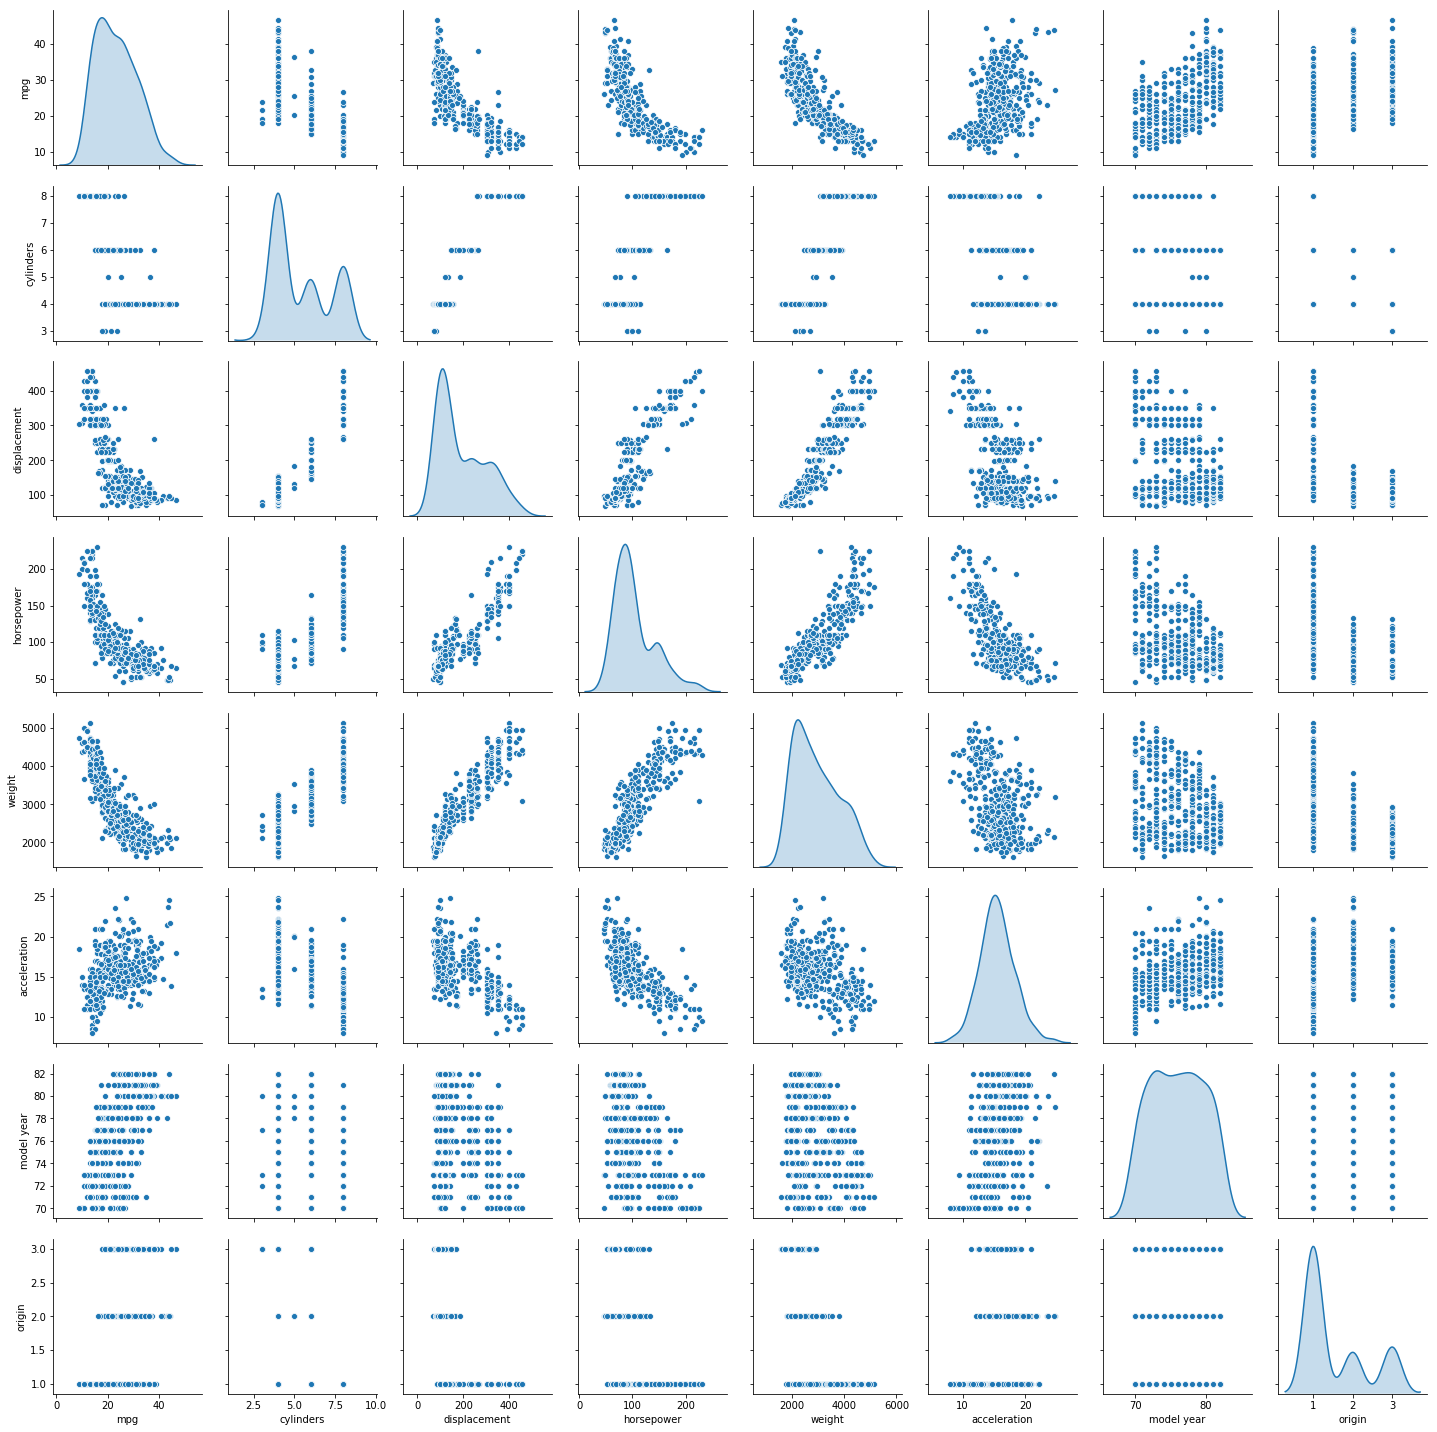

In [27]:
sns.pairplot(cars_df,diag_kind='kde')

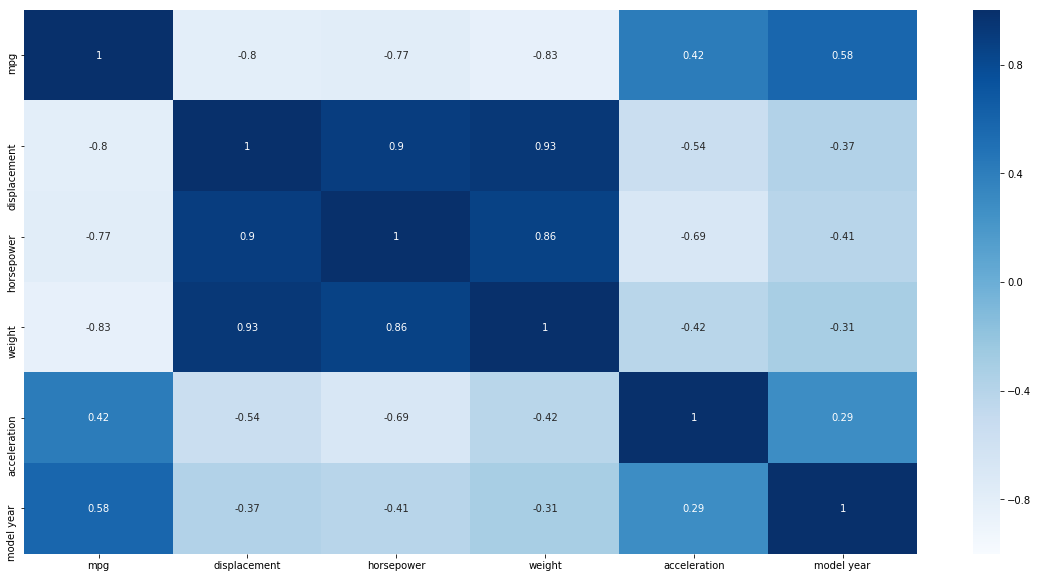

In [28]:
EDA_Corr_Results = pd.DataFrame(EDA_Corr(cars_df))

In [29]:
(EDA_Corr_Results.sort_values("Uniqueness", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
4,acceleration,4,1,2,[acceleration],"[displacement, horsepower]","[mpg, displacement, weight, model year]"
5,model year,4,2,0,"[mpg, model year]",[],"[displacement, horsepower, weight, acceleration]"
1,displacement,2,3,2,"[displacement, horsepower, weight]","[mpg, acceleration]","[acceleration, model year]"
3,weight,2,3,1,"[displacement, horsepower, weight]",[mpg],"[acceleration, model year]"
0,mpg,1,2,3,"[mpg, model year]","[displacement, horsepower, weight]",[acceleration]


In [30]:
(EDA_Corr_Results.sort_values("Positive rel", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
1,displacement,2,3,2,"[displacement, horsepower, weight]","[mpg, acceleration]","[acceleration, model year]"
2,horsepower,1,3,2,"[displacement, horsepower, weight]","[mpg, acceleration]",[model year]
3,weight,2,3,1,"[displacement, horsepower, weight]",[mpg],"[acceleration, model year]"
0,mpg,1,2,3,"[mpg, model year]","[displacement, horsepower, weight]",[acceleration]
5,model year,4,2,0,"[mpg, model year]",[],"[displacement, horsepower, weight, acceleration]"


In [31]:
(EDA_Corr_Results.sort_values("Neg", ascending= False)).head()

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
1,displacement,2,3,2,"[displacement, horsepower, weight]","[mpg, acceleration]","[acceleration, model year]"
2,horsepower,1,3,2,"[displacement, horsepower, weight]","[mpg, acceleration]",[model year]
3,weight,2,3,1,"[displacement, horsepower, weight]",[mpg],"[acceleration, model year]"
0,mpg,1,2,3,"[mpg, model year]","[displacement, horsepower, weight]",[acceleration]
4,acceleration,4,1,2,[acceleration],"[displacement, horsepower]","[mpg, displacement, weight, model year]"


In [32]:
cars_df.corr()

,mpg,displacement,horsepower,weight,acceleration,model year
mpg,1.000000,-0.804203,-0.773655,-0.831741,0.420289,0.579267
displacement,-0.804203,1.000000,0.895984,0.932824,-0.543684,-0.370164
horsepower,-0.773655,0.895984,1.000000,0.862615,-0.686843,-0.413978
weight,-0.831741,0.932824,0.862615,1.000000,-0.417457,-0.306564
acceleration,0.420289,-0.543684,-0.686843,-0.417457,1.000000,0.288137
model year,0.579267,-0.370164,-0.413978,-0.306564,0.288137,1.000000


In [33]:
#Observations
# We can see very clearly that weight, displacement and horsepower are very closely correlated

# Q5. Perform any feature engineering/transformation and remove any duplicate or irrelevant columns

In [34]:
# Further dig into data shows max mpd is for 4 cylinders vehicles
# Origin as pointed earlier indicates production point so should be broken into dummy variables
# Year would be more effective if we can transorm this to calculate age of vehicle. This dataset was used in 1983 so we would 
         #subtract year from 83 to get the age



In [35]:
cars_df['Age of car']=83-cars_df['model year']

In [36]:
cars_df.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Age of car
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,13
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,13
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,13
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,13
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,13
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500,13
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala,13
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii,13
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina,13
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl,13


In [37]:
Dummies = pd.get_dummies(cars_df['origin'],drop_first=True)

In [38]:
cars_df=cars_df.join(Dummies)

In [39]:
cars_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Age of car,2,3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,13,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,13,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,13,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,13,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,13,0,0
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500,13,0,0
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala,13,0,0
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii,13,0,0
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina,13,0,0
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl,13,0,0


# Q6. Create new data frame with standardize variables and imputation for any missing/outliers

In [40]:
# Missing value check was done above and hp column was treated with median values
# Let us check for outliers now

In [41]:
cars_df.columns

Index([         'mpg',    'cylinders', 'displacement',   'horsepower',
             'weight', 'acceleration',   'model year',       'origin',
           'car name',   'Age of car',              2,              3],
      dtype='object')

In [42]:
cars_sub = cars_df[['mpg',  'displacement',   'horsepower',
             'weight', 'acceleration']]

cars_sub_Columns = ['mpg', 'displacement',   'horsepower',
             'weight', 'acceleration']

a = cars_sub > cars_sub.quantile(0.75) + ((1.5 * EDA['IQR'])[0:5])
b = cars_sub < cars_sub.quantile(0.25) - ((1.5 * EDA['IQR'])[0:5])
cars_df[["Q31","Q32","Q33","Q34","Q35"]] = a
cars_df[["Q11","Q12","Q13","Q14","Q15"]] = b

columns = ['Q31', 'Q32', 'Q33', 'Q34', 'Q35']

Q1 =  ['Q11','Q12', 'Q13', 'Q14', 'Q15']

Q3 =  ['Q31', 'Q32', 'Q33', 'Q34', 'Q35']

In [43]:
Q1_Outliers = []
Q1_j = []
Q3_Outliers = []
Q3_j = []
for i in range(0,len(Q1)):
    i = Q1[i]
    No = cars_df.shape[0] - cars_df[i].value_counts()[0]
    Q1_Outliers.append(No)
    Q1_j.append(i)
Q1_Col = pd.DataFrame(Q1_j, columns=["Q1"])
Q1_outliers = pd.DataFrame(Q1_Outliers, columns=["Q1 Outliers"])
Outliers_impact_Q1 = Q1_Col.join(Q1_outliers)

for i in range(0,len(Q3)):
    i = Q3[i]
    No = cars_df.shape[0] - cars_df[i].value_counts()[0]
    Q3_Outliers.append(No)
    Q3_j.append(i)
Q3_Col = pd.DataFrame(Q3_j, columns=["Q3"])
Q3_outliers = pd.DataFrame(Q3_Outliers, columns=["Q3 Outliers"])
Outliers_impact_Q3 = Q3_Col.join(Q3_outliers)

Outliers_impact = Outliers_impact_Q1['Q1 Outliers']+Outliers_impact_Q3['Q3 Outliers']
Outliers_impact = (pd.DataFrame(cars_sub_Columns, columns=["Column Name"])).join(pd.DataFrame(Outliers_impact, columns=["No of Outliers"]))

In [44]:
Outliers_impact

,Column Name,No of Outliers
0,mpg,1
1,displacement,0
2,horsepower,10
3,weight,0
4,acceleration,9


In [45]:
Q3

['Q31', 'Q32', 'Q33', 'Q34', 'Q35']

In [46]:
aij = []
for i in range(0,5):
    i = Q3[i]
    bij = ((pd.DataFrame(cars_df[i])).index[(cars_df[i] == True)].tolist())
    aij = aij + bij
Q3_indices = (pd.Series(aij)).value_counts()


cij = []
for i in range(0,5):
    i = Q1[i]
    dij = ((pd.DataFrame(cars_df[i])).index[(cars_df[i] == True)].tolist())
    cij = cij + dij
Q1_indices = (pd.Series(cij)).value_counts()

In [47]:
Q3_indices

95     1
299    1
67     1
195    1
6      1
7      1
8      1
394    1
300    1
94     1
13     1
116    1
326    1
25     1
59     1
27     1
322    1
dtype: int64

In [48]:
Q1_indices

7     1
9     1
11    1
dtype: int64

In [49]:
Q3_values = cars_sub.quantile(0.75) + (1.5 * EDA['IQR'])
Q1_values = cars_sub.quantile(0.25) - (1.5 * EDA['IQR'])
Outliers_Q3_Q1 = pd.DataFrame(Q3_values, columns = ['Q3_values']).join(pd.DataFrame(Q1_values, columns=['Q1_values']))
for i in range(0,len(cars_sub_Columns)):
    Q3 = ((Outliers_Q3_Q1).T)[cars_sub_Columns[i]].loc['Q3_values']
    Q1 = ((Outliers_Q3_Q1).T)[cars_sub_Columns[i]].loc['Q1_values']
    cars_df.loc[cars_df[cars_sub_Columns[i]] > Q3, cars_sub_Columns[i]] = np.nan
    cars_df.loc[cars_df[cars_sub_Columns[i]] < Q1, cars_sub_Columns[i]] = np.nan
    median1 = ((cars_df.loc[(cars_df[cars_sub_Columns[i]]<((((Outliers_Q3_Q1).T)[cars_sub_Columns[i]])['Q3_values'])) & 
             (cars_df[cars_sub_Columns[i]]>((((Outliers_Q3_Q1).T)[cars_sub_Columns[i]])['Q1_values']))])[cars_sub_Columns[i]]).median()
    cars_df.replace(np.nan,median1,inplace= True)

In [50]:
cars_df=cars_df.iloc[:,0:12]

In [51]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 12 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
Age of car      398 non-null int64
2               398 non-null uint8
3               398 non-null uint8
dtypes: float64(5), int64(4), object(1), uint8(2)
memory usage: 30.4+ KB


In [52]:
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Age of car,2,3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,13,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,13,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,13,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,13,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,13,0,0


In [53]:
minmax_scale = MinMaxScaler()
cars_df[['mpg',  'displacement',   'horsepower','weight', 'acceleration']] = minmax_scale.fit_transform(cars_df[['mpg',  'displacement',   'horsepower','weight', 'acceleration']])
cars_df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Age of car,2,3
0,0.252809,8,0.617571,0.545455,0.536150,0.229008,70,1,chevrolet chevelle malibu,13,0,0
1,0.168539,8,0.728682,0.772727,0.589736,0.190840,70,1,buick skylark 320,13,0,0
2,0.252809,8,0.645995,0.675325,0.516870,0.152672,70,1,plymouth satellite,13,0,0
3,0.196629,8,0.609819,0.675325,0.516019,0.229008,70,1,amc rebel sst,13,0,0
4,0.224719,8,0.604651,0.610390,0.520556,0.114504,70,1,ford torino,13,0,0
5,0.168539,8,0.932817,0.987013,0.773462,0.076336,70,1,ford galaxie 500,13,0,0
6,0.140449,8,0.997416,0.298701,0.777148,0.000000,70,1,chevrolet impala,13,0,0
7,0.140449,8,0.961240,0.298701,0.765240,0.496183,70,1,plymouth fury iii,13,0,0
8,0.140449,8,1.000000,0.298701,0.797278,0.076336,70,1,pontiac catalina,13,0,0
9,0.168539,8,0.832041,0.935065,0.634250,0.496183,70,1,amc ambassador dpl,13,0,0


In [54]:
cars_scaled=cars_df

# Q7. Create appropriate clusters with the new data set

In [55]:
cars_scaled=cars_scaled.drop('car name', axis=1)

In [56]:
cluster_range = range( 1, 10)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(cars_scaled)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
  


# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,12484.659746
1,2,4284.342865
2,3,2692.930182
3,4,2128.615718
4,5,1692.857070
5,6,1442.671533
6,7,1211.888091
7,8,1069.590314
8,9,894.794870


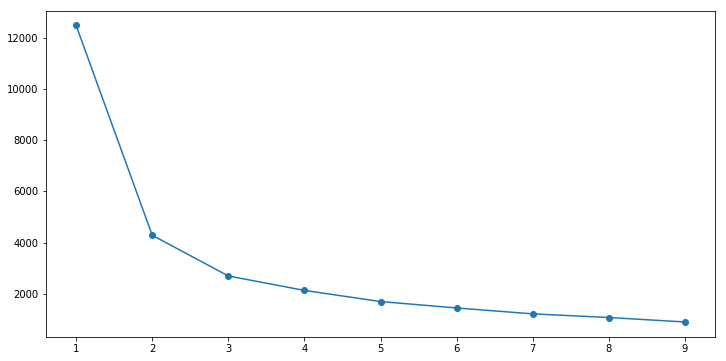

In [57]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

For n_clusters = 2 The average silhouette_score is : 0.5234901217138612
For n_clusters = 3 The average silhouette_score is : 0.43928622620140495
For n_clusters = 4 The average silhouette_score is : 0.3777174951035022


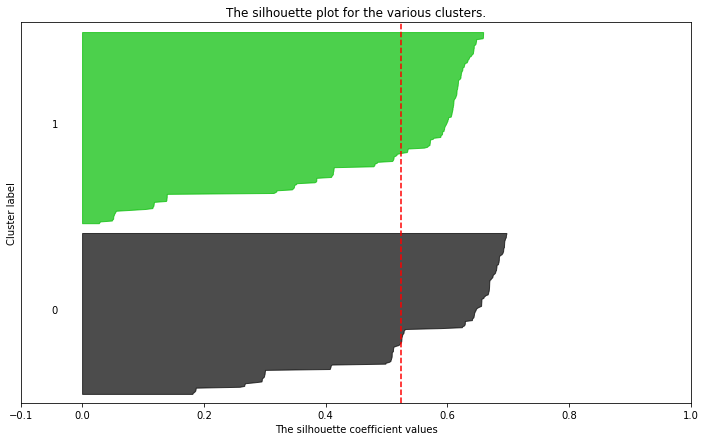

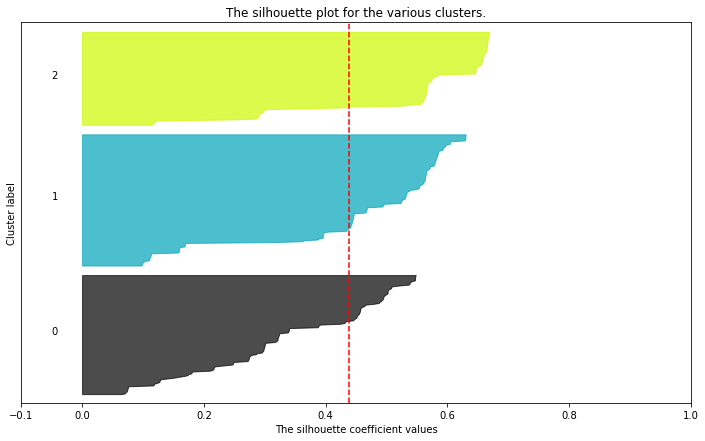

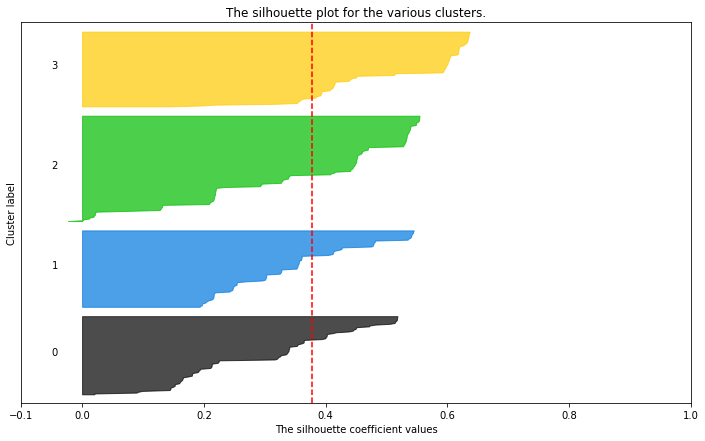

In [58]:
X = cars_scaled
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(12, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [59]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(cars_scaled)
labels = kmeans.predict(cars_scaled)
centroids = kmeans.cluster_centers_
print("Centroid values")
print(centroids)

Centroid values
[[ 0.52887702  4.93956044  0.2364767   0.29495504  0.31449384  0.53196041
  79.48351648  1.70879121  3.51648352  0.15934066  0.27472527]
 [ 0.3025515   5.88888889  0.39792684  0.41068422  0.44416223  0.46624965
  73.08333333  1.45833333  9.91666667  0.18981481  0.13425926]]


# Q8. Identify the appropriate clusters with result from above question

Covered in the working above and for the question below

# Q9. Check for no of values in each cluster and centers for each variables. 

In [60]:
prediction= kmeans.predict(cars_scaled)
cars_scaled["clusters"] = prediction

In [61]:
cars_scaled['clusters'].value_counts()

1    216
0    182
Name: clusters, dtype: int64

In [62]:
pd.DataFrame(centroids)

,0,1,2,3,4,5,6,7,8,9,10
0,0.528877,4.939560,0.236477,0.294955,0.314494,0.53196,79.483516,1.708791,3.516484,0.159341,0.274725
1,0.302551,5.888889,0.397927,0.410684,0.444162,0.46625,73.083333,1.458333,9.916667,0.189815,0.134259


# Q10. Assign the groups created above to data frame and study the characteristics  for each group.

In [63]:
cars_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Age of car,2,3,clusters
0,0.252809,8,0.617571,0.545455,0.536150,0.229008,70,1,13,0,0,1
1,0.168539,8,0.728682,0.772727,0.589736,0.190840,70,1,13,0,0,1
2,0.252809,8,0.645995,0.675325,0.516870,0.152672,70,1,13,0,0,1
3,0.196629,8,0.609819,0.675325,0.516019,0.229008,70,1,13,0,0,1
4,0.224719,8,0.604651,0.610390,0.520556,0.114504,70,1,13,0,0,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0BF7A7F0>,
      dtype=object)

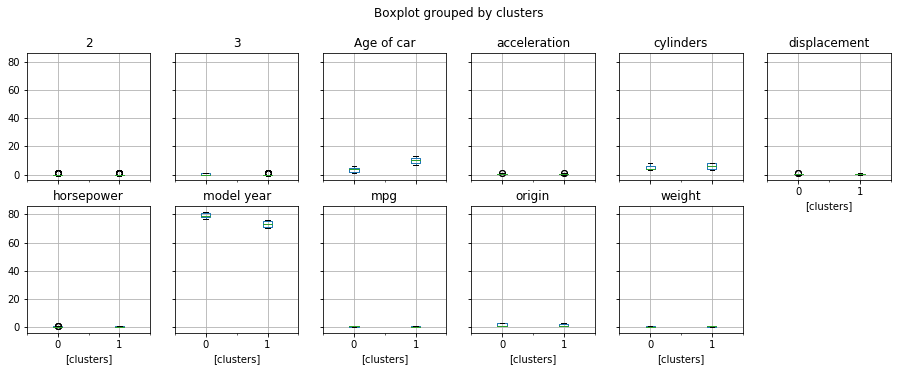

In [64]:
cars_scaled.boxplot(by = 'clusters', figsize=(15,8), layout=(3,6), )